# DELE CA2 : Deep-Q Learning

## Motivation

> This notebook is dedicated to running the DQN algorithm on the LunarLanderV2 environment and render a video of the spacecraft landing on the landing pad.

In [10]:
!pip3 install -q box2d-py

  ERROR: Command errored out with exit status 1:
   command: 'd:\anaconda3_v2\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\yuhoe\\AppData\\Local\\Temp\\pip-install-ivkup6sa\\box2d-py_eb81bf340c164fec98796958e91dd30a\\setup.py'"'"'; __file__='"'"'C:\\Users\\yuhoe\\AppData\\Local\\Temp\\pip-install-ivkup6sa\\box2d-py_eb81bf340c164fec98796958e91dd30a\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\yuhoe\AppData\Local\Temp\pip-wheel-7hezy40n'
       cwd: C:\Users\yuhoe\AppData\Local\Temp\pip-install-ivkup6sa\box2d-py_eb81bf340c164fec98796958e91dd30a\
  Complete output (28 lines):
  Using setuptools (version 50.3.1.post20201107).
  running bdist_wheel
  running build
  running build_py
  creating bu

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gym

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Replay Buffer and Experience Replay

> A buffer (temporary memory) of observations, rewards, and subsequent observations. The buffer is used to then train the Deep Learning model. 

The purpose of Experience Replay is to store past experiences and then using a random subset of these experiences to update the Q-network, rather than using just the single recent experience.

A replay buffer contains a collection of experience (State, Action, Reward, New State). Normally, a replay buffer is store as a queue, where new buffer is added to the end so that it pushes the oldest experience out of it.

In [12]:
# The ReplayBuffer class is used to store experiences in a buffer of size N. 
# The buffer is used to sample a batch of experiences from the buffer to train the agent.
class ReplayBuffer:
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    # insert experience into the buffer
    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    # Sample a batch of experiences from the buffer
    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

## Deep Q Network

> Main idea of Deep Q Network is to use a neural network to map the state space to a Q-value for each action.

A regular neural network with ReLU activation function is used to approximate the Q-function. The Q-function is a function of the state and action. The Q-function is approximated by a neural network with hidden layers. The output of the hidden layer is then used to approximate the Q-function. The Q Net is compiled with the Adam optimizer and mean squared error loss function.


In [13]:
def DeepQNetwork(lr, num_actions, input_dims, fc1, fc2):
    q_net = Sequential()
    q_net.add(Dense(fc1, input_dim=input_dims, activation='relu'))
    q_net.add(Dense(fc2, activation='relu'))
    q_net.add(Dense(num_actions, activation=None))
    q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return q_net

# Agent

## Target Network

> A target network is a copy of the estimated value function that is held fixed to serve as a stable target for some number of steps.

When we alter the neural network parameters to $Q(s,a)$, it make alter $Q(s',a')$ and other states nearby, which is determined to make training very unstable.

To make training more stabel, copying over the Q Net over to the target network and use it for the $Q(s', a')$. 

## Policy

The policy takes the highest Q-value of the current state and chooses the action with the highest Q-value. For the first few episodes, the agent will explore the environment by randomly choosing actions.

$a \leftarrow argmax Q(s, a_s; \theta)$


In [14]:
# Agenet class to train by interacting with the environment
class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dims):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.001
        self.epsilon_final = 0.01
        self.update_rate = 120
        self.step_counter = 0
        self.buffer = ReplayBuffer(1000000, input_dims)
        self.q_net = DeepQNetwork(lr, num_actions, input_dims, 256, 256)
        self.q_target_net = DeepQNetwork(lr, num_actions, input_dims, 256, 256)

    def store_tuple(self, state, action, reward, new_state, done):
        '''
        Store the tuple (state, action, reward, new_state, done) in the buffer
        
        state: The state of the environment before the agent took the action
        action: The action taken by the agent in the current state
        reward: The reward received for performing action in state
        new_state: The state the agent is in after performing the action
        done: A boolean that indicates whether the episode has finished
        '''
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        # Expores the env using random actions in the first few episodes
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            # Expores the env using random actions in the first few episodes
            state = np.array([observation])
            actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        '''
        Update the Q-network by training on a batch sampled from the replay buffer
        return: The agent's behaviour.
        '''
        if self.buffer.counter < self.batch_size:
            return
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())

        state_batch, action_batch, reward_batch, new_state_batch, done_batch = \
            self.buffer.sample_buffer(self.batch_size)

        q_predicted = self.q_net(state_batch)
        q_next = self.q_target_net(new_state_batch)
        q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
        q_target = np.copy(q_predicted)

        for idx in range(done_batch.shape[0]):
            target_q_val = reward_batch[idx]
            if not done_batch[idx]:
                target_q_val += self.discount_factor*q_max_next[idx]
            q_target[idx, action_batch[idx]] = target_q_val
        self.q_net.train_on_batch(state_batch, q_target)
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_final else self.epsilon_final
        self.step_counter += 1

    # Main Function to train DQN
    def train_model(self, env, num_episodes, graph):
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        f = 0
        txt = open("saved_networks.txt", "w")

        # This is the code that is used to train the agent. The agent is trained for a number of episodes.
        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            while not done:
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            scores.append(score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon,
                                                                             avg_score))
            
            # Saves the network's weights when avg score larger than 200 and score larger than 250
            if avg_score >= 200.0 and score >= 250:
                self.q_net.save(("saved_networks/dqn_model{0}".format(f)))
                self.q_net.save_weights(("saved_networks/dqn_model{0}/net_weights{0}.h5".format(f)))
                txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,
                                                                                                  score, self.epsilon,
                                                                                                  avg_score))
                f += 1
                print("Network saved")

        txt.close()

        ## Creating Train Learning Curve
        df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

        with plt.style.context('ggplot'):
            fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
            ax.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            ax.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                    label='AverageScore')
            ax.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                    label='Solved Requirement')
            ax.legend()
            fig.savefig('Train Learning Curve.png')

    # Main Function to test the trained DQN on a rendered Env
    def test(self, env, num_episodes, file_type, file, graph):
        # Loading the DQN weights from the saved  model
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon, avg_score))

        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
                ax.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                ax.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                ax.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                ax.legend()
                fig.savefig('Test Learning Curve.png')
                plt.show()

        env.close()

Episode 0/100, Score: 256.3161931114556 (0.0), AVG Score: 256.3161931114556
Episode 1/100, Score: 499.6670867080334 (0.0), AVG Score: 249.8335433540167
Episode 2/100, Score: 758.6089275665245 (0.0), AVG Score: 252.86964252217481
Episode 3/100, Score: 651.6083732474297 (0.0), AVG Score: 162.9020933118574
Episode 4/100, Score: 934.8570838500323 (0.0), AVG Score: 186.97141677000644
Episode 5/100, Score: 1199.7933386076588 (0.0), AVG Score: 199.9655564346098
Episode 6/100, Score: 1445.0829182628706 (0.0), AVG Score: 206.4404168946958
Episode 7/100, Score: 1706.7194583278683 (0.0), AVG Score: 213.33993229098354
Episode 8/100, Score: 1912.8468614119101 (0.0), AVG Score: 212.5385401568789
Episode 9/100, Score: 2151.5478944054776 (0.0), AVG Score: 215.15478944054775
Episode 10/100, Score: 2422.9925409733764 (0.0), AVG Score: 220.27204917939787
Episode 11/100, Score: 2681.5852312153042 (0.0), AVG Score: 223.46543593460868
Episode 12/100, Score: 2929.4537179230574 (0.0), AVG Score: 225.342593686

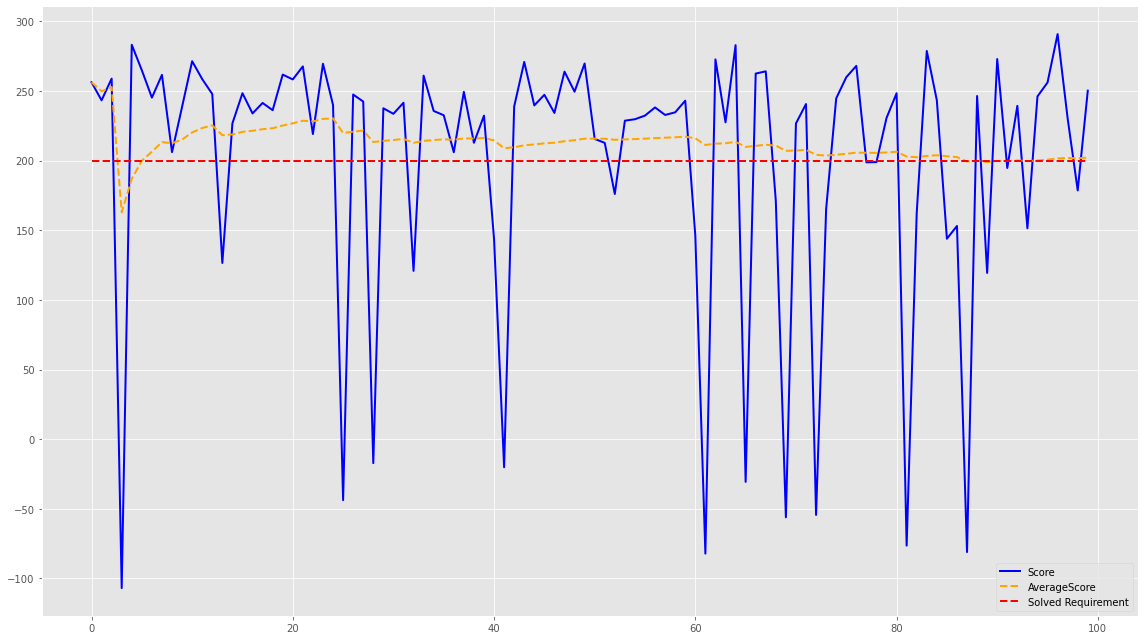

In [15]:
# Creating the environment and setting the specs for the environment.
env = gym.make("LunarLander-v2")
spec = gym.spec("LunarLander-v2")
num_episodes = 100
graph = True

file_type = 'tf'
file = 'saved_networks/run_2dqn_model80'

# Creating an instance of the Agent class.
dqn_agent = Agent(lr=0.00075, discount_factor=0.99, num_actions=4, epsilon=0.01, batch_size=64, input_dims=8)

# Test DQN with rendered environment with video recording
monitor = gym.wrappers.Monitor(env, './videos/', force=True)
dqn_agent.test(monitor, num_episodes, file_type, file, graph)